## Grid explorer

In this notebook you will see how to:

- inspect the grid properties of GRIB data
- access the latitudes/longitudes of a field
- plot the gridpoints of a field
- interpolate GRIB data from one grid to another (regridding)
- extract the nearest gridpoint from a field

You will work with the following earthkit components:
- [earthkit-data](https://earthkit-data.readthedocs.io/en/latest/)
- [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/)
- [earthkit-regrid](https://earthkit-regrid.readthedocs.io/en/latest/)
- [earthkit-geo](https://earthkit-geo.readthedocs.io/en/latest/)

### Getting the data

The input data is a GRIB file containing 1000 hPa temperature fields on 3 different global grids. 

First, fetch the file and list its contents.

In [1]:
import earthkit as ek

ds = ek.data.from_source("sample", "grids_3.grib")
ds.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,t,isobaricInhPa,1000,20150422,1200,0,an,None,regular_ll
1,ecmf,t,isobaricInhPa,1000,20150422,1200,0,an,None,reduced_gg
2,ecmf,t,isobaricInhPa,1000,20150422,1200,0,an,None,healpix


Next, select the field you will inspect in the rest of the notebook.

To try another grid type change the `gridType` in the `sel()` call below and rerun the notebook.

In [2]:
# choose one from: regular_ll, reduced_gg, healpix
f = ds.sel(gridType="regular_ll")[0] 
f.metadata("gridType")

'regular_ll'

### Inspecting the grid

With `dump()` you can inspect all the relevant GRIB metadata.

In [3]:
f.dump(namespace="geography")

Ni,72
Nj,37
iScansNegatively,0
jScansPositively,0
jPointsAreConsecutive,0
latitudeOfFirstGridPointInDegrees,90.0
longitudeOfFirstGridPointInDegrees,0.0
latitudeOfLastGridPointInDegrees,-90.0
longitudeOfLastGridPointInDegrees,355.0
iDirectionIncrementInDegrees,5.0
jDirectionIncrementInDegrees,5.0


The field's shape is derived from the geography. For grids with  regular 2D structure, like regular latitude-longitude grids, the shape is always 2D. Otherwise, like for reduced Gaussian grids, it is 1D.

In [4]:
f.shape

(37, 72)

When you access the latitudes and longitudes via `to_latlon()` you get numpy arrays with the field's shape.

In [5]:
ll = f.to_latlon()
ll["lat"].shape, ll["lon"].shape

((37, 72), (37, 72))

In [6]:
ll["lon"]

array([[  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.],
       ...,
       [  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.]])

In [7]:
ll["lat"]

array([[ 90.,  90.,  90., ...,  90.,  90.,  90.],
       [ 85.,  85.,  85., ...,  85.,  85.,  85.],
       [ 80.,  80.,  80., ...,  80.,  80.,  80.],
       ...,
       [-80., -80., -80., ..., -80., -80., -80.],
       [-85., -85., -85., ..., -85., -85., -85.],
       [-90., -90., -90., ..., -90., -90., -90.]])

You can access the field values either with `to_numpy()` or via the `values` property. By default, `to_numpy()` respects the field's shape unless you use the `flatten=True` option.

In [8]:
f.to_numpy().shape, f.to_numpy(flatten=True).shape

((37, 72), (2664,))

When using the `values` property always a 1D array is returned.

In [9]:
f.values.shape

(2664,)

### Plotting the gridpoints

This example shows you how to plot the original gridpoint positions of the field.

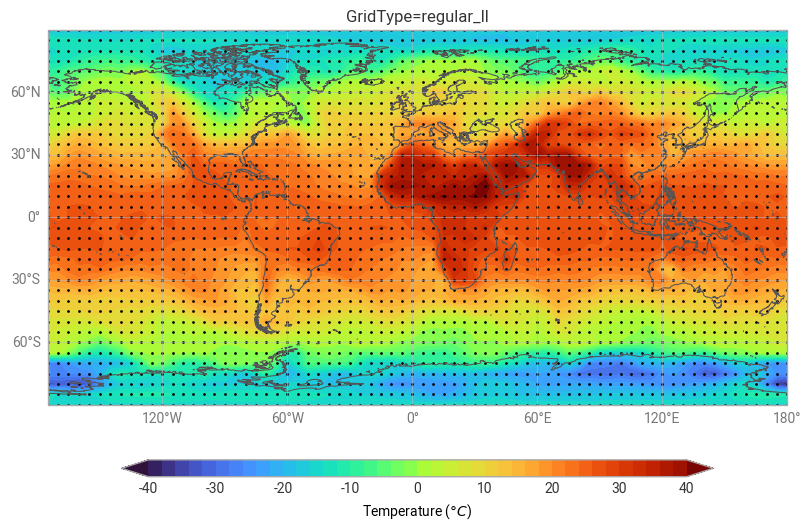

In [10]:
chart = ek.plots.Map()
chart.contourf(f, units="celsius", auto_style=True)
# plot the original grid points
chart.grid_points(f, c="black") #marker="+"
chart.title(f"gridType={f.metadata('gridType')}")
chart.coastlines()
chart.gridlines()
chart.legend()

chart.show()

This plot variant shows a smaller area and displays the grid values at each grid point.

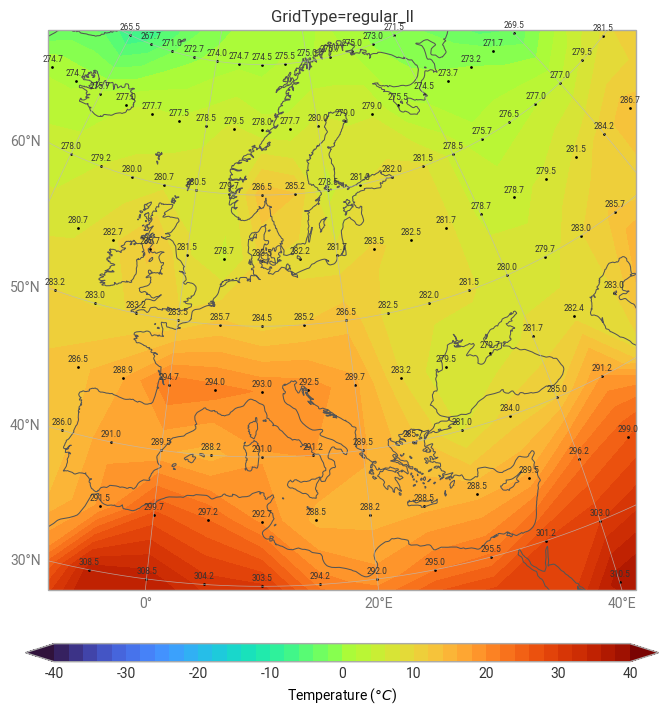

In [11]:
import cartopy.crs as ccrs

chart = ek.plots.Map(domain="Europe")
chart.contourf(f, units="celsius", auto_style=True)
# plot the original grid points
chart.grid_points(f, c="black") #marker="+"

# generate grid values
lat, lon, vals = f.data(flatten=True)
labels = [f"{x:.1f}" for x in vals]
for i, lbs in enumerate(labels):
    chart.ax.annotate(lbs, (lon[i], lat[i]), transform=ccrs.Geodetic(), 
                      xytext=(0,5),
                      textcoords="offset pixels", 
                      annotation_clip=True, 
                      fontsize=6, horizontalalignment="center")

chart.title(f"gridType={f.metadata('gridType')}")
chart.coastlines()
chart.gridlines()
chart.legend()

chart.show()

### Regridding

You can regrid data with [earthkit.regrid.interpolate()](https://earthkit-regrid.readthedocs.io/en/latest/interpolate.html#interpolate). At the moment, earthkit-regrid uses a set of pre-generated interpolation weights downloaded automatically from a remote ECMWF repository. Only a limited set of global grid-to-grid combinations are supported (the ones the interpolation weights are available for). For the full list see the [inventory](https://earthkit-regrid.readthedocs.io/en/latest/inventory/index.html).

In [12]:
# the target grid is a global 10x10 degree regular latitude-longitude grid
grid = {"grid": [10,10]}

# interpolate cannot read a single field but a fieldlist, so 
# we convert f into a fieldlist
ds_f =  ek.data.FieldList.from_fields([f])

# perform interpolation for each field and add results
# to a new fieldlist stored in memory
ds_res = ek.regrid.interpolate(ds_f, out_grid=grid, interpolation="linear")

The next cell plots the original and interpolated fields over a subarea.

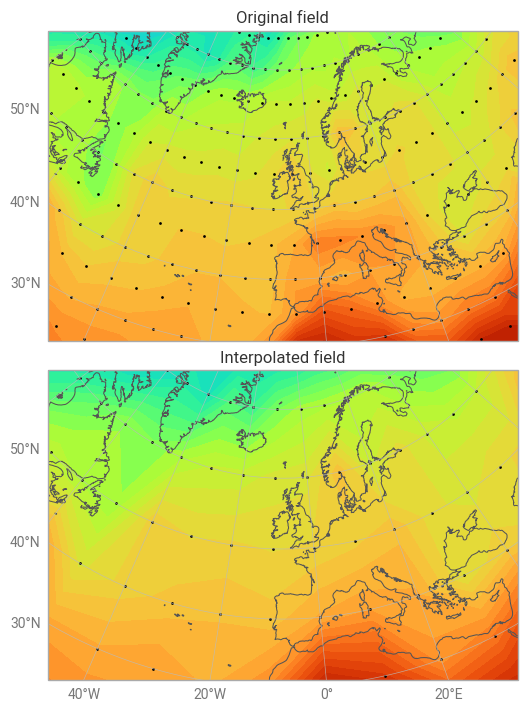

In [16]:
figure = ek.plots.Figure(domain="North Atlantic", rows=2, columns=1)

# the original field
subplot = figure.add_map(0, 0)
subplot.contourf(f, units="celsius", auto_style=True)
subplot.grid_points(f, c="black")
subplot.title("Original field")
# subplot.legend(label="")

# the interpolated field
subplot = figure.add_map(1, 0)
subplot.contourf(ds_res[0], units="celsius", auto_style=True)
subplot.grid_points(ds_res[0], c="black")
subplot.title("Interpolated field")
# subplot.legend(label="")

figure.coastlines()
figure.gridlines()

figure.show()

### Getting the nearest gridpoint

In this example you can see how to extract the nearest gridpoint value of a field using [earthkit.geo.nearest_point_haversine()](https://earthkit-geo.readthedocs.io/en/latest/_api/geo/distance/index.html#geo.distance.nearest_point_haversine).

In [14]:
# ref location (lat, lon)
p_ref = (51.45, -0.97)

# get latlon
latlon = f.to_latlon()
lat = latlon["lat"]
lon = latlon["lon"]

# get nearest point index
idx, dist = ek.geo.nearest_point_haversine(p_ref, (lat, lon))
idx

array([576])

In [15]:
# extract field value at given index
f.values[idx]

array([283.45458984])